# Chapter 4. Geocentric Models

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

from jax import lax, random, vmap
import jax.numpy as jnp

import numpyro
from numpyro.diagnostics import hpdi, print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")

### Code 4.1

In [2]:
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

### Code 4.2

In [3]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

DeviceArray(1.7294353, dtype=float32)

### Code 4.3

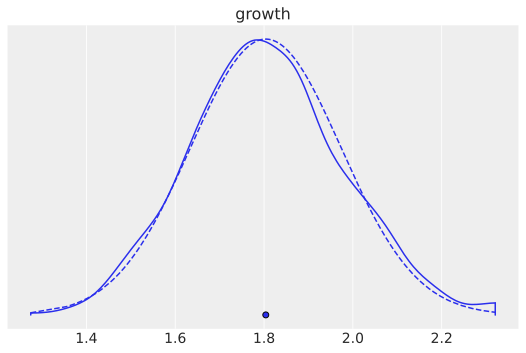

In [4]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)
az.plot_density({"growth": growth}, credible_interval=1)
x = jnp.sort(growth)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--");

### Code 4.4

In [5]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)

### Code 4.5

In [6]:
log_big = jnp.log(jnp.prod(
    1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1))

### Code 4.6

In [7]:
w = 6; n = 9
p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)

### Code 4.7

In [8]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

### Code 4.8

In [9]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

### Code 4.9

In [10]:
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



### Code 4.10

In [11]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11

In [12]:
d2 = d[d.age >= 18]

### Code 4.12

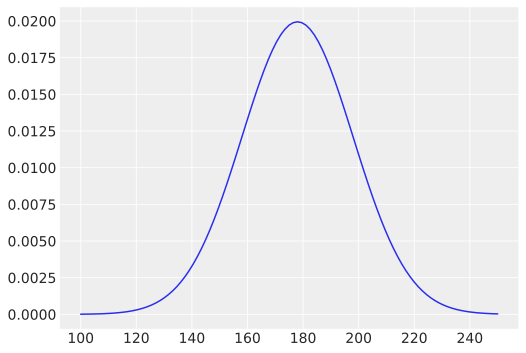

In [13]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)));

### Code 4.13

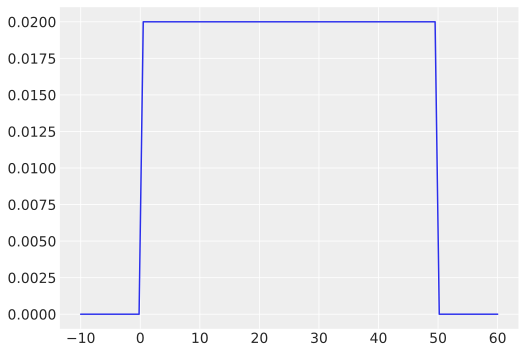

In [14]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)));

### Code 4.14

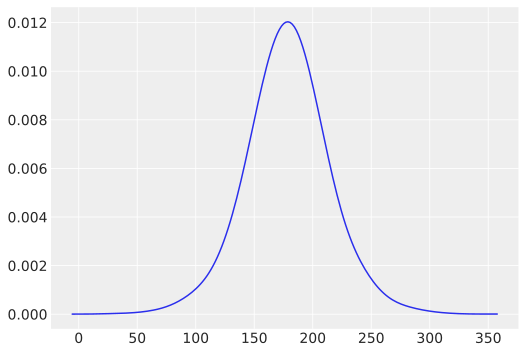

In [15]:
sample_mu = dist.Normal(178, 20).sample(random.PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h);

### Code 4.15

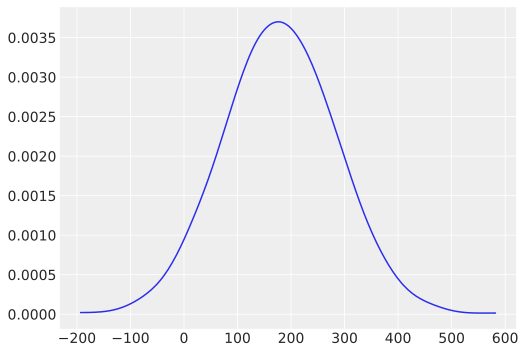

In [16]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h);

### Code 4.16

In [17]:
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(
    d2.height.values)))(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

### Code 4.17

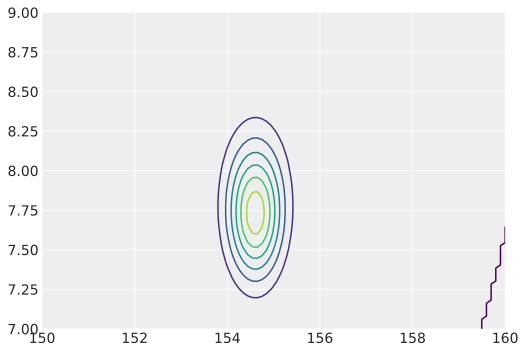

In [18]:
plt.contour(post["mu"].reshape(100, 100), post["sigma"].reshape(100, 100),
            post["prob"].reshape(100, 100));

### Code 4.18

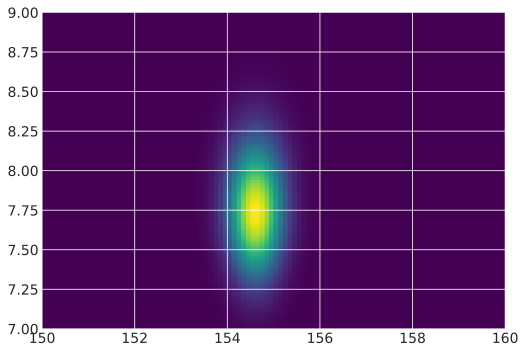

In [19]:
plt.imshow(post["prob"].reshape(100, 100),
           origin="lower", extent=(150, 160, 7, 9), aspect="auto");

### Code 4.19

In [20]:
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.20

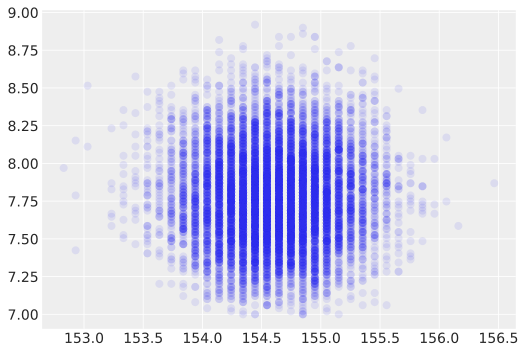

In [21]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none");

### Code 4.19

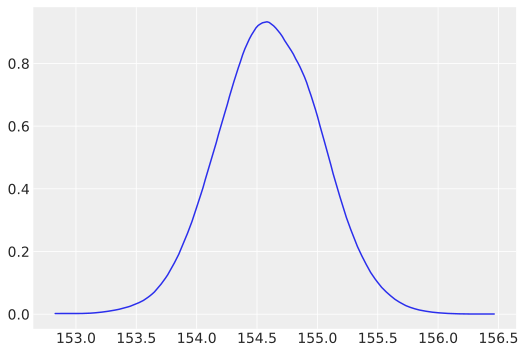

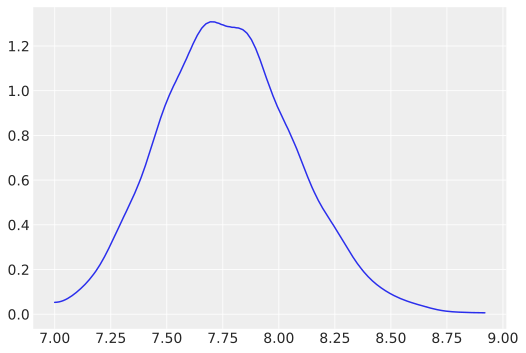

In [22]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma);

### Code 4.22

In [23]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


### Code 4.23

In [24]:
d3 = d2.height.sample(n=20)

### Code 4.24

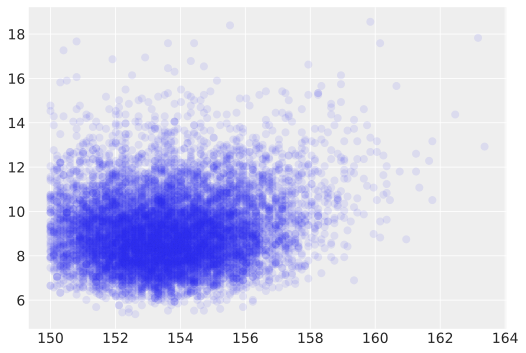

In [25]:
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(lambda mu, sigma: jnp.sum(
    dist.Normal(mu, sigma).log_prob(d3.values)))(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none");

### Code 4.25

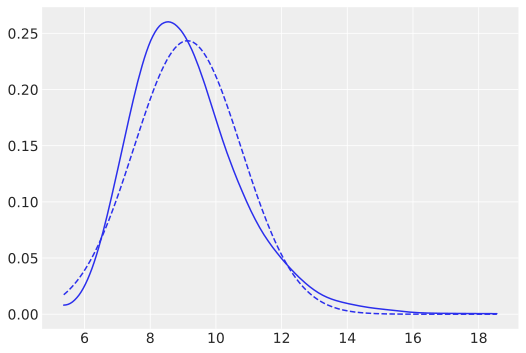

In [26]:
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--");

### Code 4.26

In [27]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

### Code 4.27

In [28]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Code 4.28

In [29]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_1 = svi.get_params(state)

NameError: name 'AutoContinuousELBO' is not defined

### Code 4.29

In [ ]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)

### Code 4.30

In [ ]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_strategy=init_to_value(start))
svi = SVI(flist, m4_1, optim.Adam(0.1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_1 = svi.get_params(state)

### Code 4.31

In [ ]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p4_2 = svi.get_params(state)
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

### Code 4.32

In [ ]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
vcov

### Code 4.33

In [ ]:
print(jnp.diagonal(vcov))
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

### Code 4.34

In [ ]:
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

### Code 4.35

In [ ]:
print_summary(post, 0.89, False)

### Code 4.36

In [ ]:
samples_flat = jnp.stack(list(post.values()))
mu, sigma = jnp.mean(samples_flat), jnp.cov(samples_flat)
post = dist.MultivariateNormal(mu, sigma).sample(random.PRNGKey(0), (int(1e4),))

### Code 4.37

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"));

### Code 4.38

In [ ]:
with numpyro.handlers.seed(rng=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20), sample_shape=(N,))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(N,))

### Code 4.39

In [ ]:
plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);

### Code 4.40

In [ ]:
b = dist.LogNormal(0, 1).sample(random.PRNGKey(0), (int(1e4),))
az.plot_kde(b);

### Code 4.41

In [ ]:
with numpyro.handlers.seed(rng=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 28), sample_shape=(N,))
    b = numpyro.sample("b", dist.LogNormal(0, 1), sample_shape=(N,))

### Code 4.42

In [ ]:
# load data again, since it's a long way back
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - xbar)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3, optim.Adam(1), AutoContinuousELBO(),
          weight=d2.weight.values, height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_3 = svi.get_params(state)

### Code 4.43

In [ ]:
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + jnp.exp(log_b) * (weight - xbar)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3b = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3b, optim.Adam(1), AutoContinuousELBO(),
          weight=d2.weight.values, height=d2.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_3b = svi.get_params(state)

### Code 4.44

In [ ]:
samples = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
print_summary(samples, 0.89, False)

### Code 4.45

In [ ]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

### Code 4.46

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k");

### Code 4.47

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent][:5]) for latent in post}

### Code 4.48

In [ ]:
N = 10
dN = d2[:N]

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

mN = AutoLaplaceApproximation(model)
svi = SVI(model, mN, optim.Adam(1), AutoContinuousELBO(),
          weight=dN.weight.values, height=dN.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
pN = svi.get_params(state)

### Code 4.49

In [ ]:
# extract 20 samples from the posterior
post = mN.sample_posterior(random.PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(xlim=(d2.weight.min(), d2.weight.max()),
       ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()),
             "k", alpha=0.3)

### Code 4.50

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

### Code 4.51

In [ ]:
az.plot_kde(mu_at_50, label="mu|weight=50");

### Code 4.52

In [ ]:
jnp.percentile(mu_at_50, q=(5.5, 94.5))

### Code 4.53

In [ ]:
mu = Predictive(m4_3.model, post, return_sites=["mu"]).get_samples(
    random.PRNGKey(2), d2.weight.values, d2.height.values)["mu"]
mu.shape, list(mu[:5, 0])

### Code 4.54

In [ ]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"]).get_samples(
    random.PRNGKey(2), weight_seq, None)["mu"]
mu.shape, list(mu[:5, 0])

### Code 4.55

In [ ]:
# use plot_kwargs={"alpha": 0} to hide raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0})

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

### Code 4.56

In [ ]:
# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)

### Code 4.57

In [ ]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 4.58

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

### Code 4.59

In [ ]:
sim_height = Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    random.PRNGKey(2), weight_seq, None)["height"]
sim_height.shape, list(sim_height[:5, 0])

### Code 4.60

In [ ]:
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.61

In [ ]:
# plot raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k",
                 alpha=0.15);

### Code 4.62

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, sample_shape=(int(1e4),))
sim_height = Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    random.PRNGKey(2), weight_seq, None)["height"]
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.63

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71)
sim_height = vmap(lambda i, weight:
                  dist.Normal(post["a"] + post["b"] * (weight - xbar))
                  .sample(random.PRNGKey(i)))(jnp.arange(len(weight_seq)), weight_seq)
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.64

In [ ]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

### Code 4.65

In [ ]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2

def model(weight_s, weight_s2, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_5, optim.Adam(0.3), AutoContinuousELBO(),
          weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
          height=d.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_5 = svi.get_params(state)

### Code 4.66

In [ ]:
samples = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
print_summary(samples, 0.89, False)

### Code 4.67

In [ ]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2,
            "height": None}
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post, return_sites=["mu", "height"])
mu = predictive.get_samples(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
sim_height = predictive.get_samples(random.PRNGKey(2), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.68

In [ ]:
az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k",
                 alpha=0.15);

### Code 4.69

In [ ]:
d["weight_s3"] = d.weight_s ** 3

def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_6, optim.Adam(0.3), AutoContinuousELBO(),
          weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
          weight_s3=d.weight_s3.values, height=d.height.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_6 = svi.get_params(state)

### Code 4.70

In [ ]:
ax = az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"),
                  plot_kwargs={"alpha": 0.5})
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

### Code 4.71

In [ ]:
at = jnp.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
fig

### Code 4.72

In [ ]:
cherry_blossoms = pd.read_csv("../data/cherry_blossoms.csv", sep=";")
d = cherry_blossoms
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)

### Code 4.73

In [ ]:
d2 = d[d.temp.notna()]  # not NaN cases on temp
num_knots = 15
knot_list = jnp.quantile(d2.year.values.astype(float),
                        q=jnp.linspace(0, 1, num=num_knots))

### Code 4.74

In [ ]:
knots = ojnp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, jnp.identity(num_knots + 2), k=3)(d2.year.values)

### Code 4.75

In [ ]:
plt.subplot(xlim=(d2.year.min(), d2.year.max()), ylim=(0, 1),
            xlabel="year", ylabel="basis value")
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

### Code 4.76

In [ ]:
def model(B, T):
    a = numpyro.sample("a", dist.Normal(6, 10))
    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=B.shape[1:])
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + B @ w
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)

start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_strategy=init_to_value(start))
svi = SVI(model, m4_7, optim.Adam(1), AutoContinuousELBO(),
          B=B, T=d2.temp.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_7 = svi.get_params(state)

### Code 4.77

In [ ]:
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post["w"], 0)
plt.subplot(xlim=(d2.year.min(), d2.year.max()), ylim=(-2, 2),
            xlabel="year", ylabel="basis * weight")
for i in range(B.shape[1]):
    plt.plot(d2.year, w[i] * B[:, i], "k", alpha=0.5)

### Code 4.78

In [ ]:
mu = Predictive(m4_7.model, post, return_sites=["mu"]).get_samples(
    random.PRNGKey(2), B, None)["mu"]
mu_PI = jnp.percentile(mu, q=(1.5, 98.5), axis=0)
az.plot_pair(d2[["year", "temp"]].astype(float).to_dict(orient="list"),
             plot_kwargs={"c": "royalblue", "alpha": 0.3})
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5);

### Code 4.79

In [ ]:
def model(B, T):
    a = numpyro.sample("a", dist.Normal(6, 10))
    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=B.shape[1:])
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + jnp.sum(B * w, axis=-1)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)

start = {"w": jnp.zeros(B.shape[1])}
m4_7alt = AutoLaplaceApproximation(model, init_strategy=init_to_value(start))
svi = SVI(model, m4_7alt, optim.Adam(1), AutoContinuousELBO(),
          B=B, T=d2.temp.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_7alt = svi.get_params(state)

### Code 4.80

In [ ]:
az.plot_pair(Howell1[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.4});